In [283]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display

from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV
import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    log_loss, confusion_matrix, classification_report,
    roc_auc_score, matthews_corrcoef, cohen_kappa_score, 
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [284]:
df = pd.read_csv("Dataset_2_DATA.csv")
display(df)

,HHID,PERSID,VPLID,RitID,HH_VALID,P_VALID,KHVM,WEGGEWEEST,VERTREKP,AANTVPL,...,HHAUTO_N,HHAUTO,HHBESTEL,HHHYBRID,HHMOTOR,HHBROM,HHSNOR,HHFIETS,HHVOUWFIETS,HHEBIKE
0,30055622,3005562201,13957101,1395710101,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
1,30055622,3005562201,13957102,1395710201,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
2,30055622,3005562201,13957201,1395720101,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
3,30055622,3005562201,13957202,1395720201,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
4,30204076,3020407601,14445303,1444530301,2,3,8,1,1,3,...,2,1,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7305,30862294,3086229401,19042304,1904230401,2,3,2,1,2,12,...,1,1,0,0,0,0,0,1,0,0
7306,30862294,3086229401,19042103,1904210301,2,3,7,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7307,30862294,3086229401,19042104,1904210401,2,3,7,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7308,30862294,3086229401,19042201,1904220101,2,3,1,1,2,3,...,1,1,0,0,0,0,0,1,0,0


# Анализ и обработка пропусков/нулевых значений

In [285]:
df = df.replace({' ': np.nan})
missing_values = df.isnull().sum()

missing_values

HHID                        0
PERSID                      0
VPLID                       0
RitID                       0
HH_VALID                    0
P_VALID                     0
KHVM                        0
WEGGEWEEST                  0
VERTREKP                    0
AANTVPL                     0
VPLDAGNR                    0
VERPL                       0
VERPLNR                     0
TOER                        0
TOER_TYPE                   0
AANTRIT                     0
KMOTIEF                     0
VERTPROV                    0
AANKPROV                    0
KAFSTV                      0
KVERTTIJD                   0
KREISDUUR                  81
ROLAUTO                     0
PARKEERKOSTEN              21
VERTRAGING                  0
DAGSOORT                    0
OORDEEL_AUTO                0
OORDEEL_TREIN               0
OORDEEL_BTM                 0
OORDEEL_FIETS               0
OORDEEL_BROMMER             0
OORDEEL_LOPEN               0
GEBRUIK_AUTO_STELLING3      0
GEBRUIK_AU

Пропуски в двух столбцах. Столбец KREISDUUR содержит информацию о времени поездки. Столбец PARKEERKOSTEN содержит информацию о цене парковки. Оба столбца категориальные (закодированы номерами категорий), можно заменить на моду

In [286]:
mode_value = df['KREISDUUR'].mode()[0]
df['KREISDUUR'] = df['KREISDUUR'].fillna(mode_value)

mode_value1 = df['PARKEERKOSTEN'].mode()[0]
df['PARKEERKOSTEN'] = df['PARKEERKOSTEN'].fillna(mode_value1)

df['KREISDUUR'] = df['KREISDUUR'].astype('int64')
df['PARKEERKOSTEN'] = df['PARKEERKOSTEN'].astype('int64')

In [287]:
df_replaced = df.replace(0, np.nan)
missing_values = df_replaced.isnull().sum()

missing_values

HHID                          0
PERSID                        0
VPLID                         0
RitID                         0
HH_VALID                      0
P_VALID                       0
KHVM                          0
WEGGEWEEST                    0
VERTREKP                      0
AANTVPL                       0
VPLDAGNR                      2
VERPL                      1395
VERPLNR                       0
TOER                       6953
TOER_TYPE                     0
AANTRIT                       0
KMOTIEF                       0
VERTPROV                    109
AANKPROV                    102
KAFSTV                        0
KVERTTIJD                     0
KREISDUUR                     0
ROLAUTO                    4728
PARKEERKOSTEN              7207
VERTRAGING                 6946
DAGSOORT                      0
OORDEEL_AUTO                  0
OORDEEL_TREIN                 0
OORDEEL_BTM                   0
OORDEEL_FIETS                 0
OORDEEL_BROMMER               0
OORDEEL_

Довольно много нулевых значений в некоторых колонках. Проверяем их смысл по описанию датасета: 
   1. VPLDAGNR: запись до начала отсчёта 
   2. VERPL: отсутствие поездки
   3. TOER: точка отъезда не совпадает с точкой прибытия
   4. VERTPROV: точка отправления не в Нидерландах 
   5. AANKPROV: точка прибытия не в Нидерландах
   6. ROLAUTHHBESTELO: поездка не на автомобиле 
   7. VERTRAGING: без опозданий 
   8. N_KIND: количество детей до 12 лет в домовладении 
   9. HHAUTO_N: количество автомобилей в домовладении
   10. HHAUTO: отсутствие автомобилей в домовладении 
   11. HHBESTEL: отсутствие фургона в домовладении 
   12. HHHYBRID: отсутствие электро/гибридного/водородного автомобиля в домовладении
   13. HHMOTOR: отсутствие мотоцилка в домовладении 
   14. HHBROM: отсутствие мопеда в домовладении 
   15. HHSNOR: отсутствие легкового мопеда в домовладении
   16. HHFIETS: отсутствие велосипеда в домовладении
   17. HHVOUWFIETS: отсутствие складного велосипеда в домовладении
   18. HHEBIKE: отсутствие электровелосипеда в домовладении

Похоже, в нашем датасете нет пропусков, заполненных нулём. Также вызвали сомнения некоторых колонки, в которых возможно значение 0, но не встречается ни в одной строке. Возможно была проведена предобработка с заполнением пропусков, например, на моду по колонке.

In [288]:
num_duplicates = df.duplicated().sum()
print(f'Количество дубликатов: {num_duplicates}')

Количество дубликатов: 0


In [289]:
df.drop([col for col in df if df[col].nunique()==1], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7310 entries, 0 to 7309
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   HHID                     7310 non-null   int64
 1   PERSID                   7310 non-null   int64
 2   VPLID                    7310 non-null   int64
 3   RitID                    7310 non-null   int64
 4   KHVM                     7310 non-null   int64
 5   VERTREKP                 7310 non-null   int64
 6   AANTVPL                  7310 non-null   int64
 7   VPLDAGNR                 7310 non-null   int64
 8   VERPL                    7310 non-null   int64
 9   VERPLNR                  7310 non-null   int64
 10  TOER                     7310 non-null   int64
 11  TOER_TYPE                7310 non-null   int64
 12  AANTRIT                  7310 non-null   int64
 13  KMOTIEF                  7310 non-null   int64
 14  VERTPROV                 7310 non-null   int64
 15  AANK

In [290]:
df = df[df['KAFSTV'] >= 4] # по условию 7 варианта KAFSTV(Distance class trip) больше 3.5 км
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4546 entries, 0 to 7309
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   HHID                     4546 non-null   int64
 1   PERSID                   4546 non-null   int64
 2   VPLID                    4546 non-null   int64
 3   RitID                    4546 non-null   int64
 4   KHVM                     4546 non-null   int64
 5   VERTREKP                 4546 non-null   int64
 6   AANTVPL                  4546 non-null   int64
 7   VPLDAGNR                 4546 non-null   int64
 8   VERPL                    4546 non-null   int64
 9   VERPLNR                  4546 non-null   int64
 10  TOER                     4546 non-null   int64
 11  TOER_TYPE                4546 non-null   int64
 12  AANTRIT                  4546 non-null   int64
 13  KMOTIEF                  4546 non-null   int64
 14  VERTPROV                 4546 non-null   int64
 15  AANKPROV 

Датасет причёсан, можно приступать к анализу и обработке 

# EDA

Соединим датафреймы, чтобы было удобнее анализировать категории 

In [291]:
description_df = pd.read_csv('Dataset_2_DESCRIPTION.csv', encoding='latin1')
description_df

,Variable,Var_description,Value,Label,Measurement_level,BaseData_Type,Name_BaseData,Filter_Variables
0,PERSOON,new person,0,no new person,Nominal,Mobility,MPNWAVE6_DAGBOEKdata,1
1,PERSOON,new person,1,new person,Nominal,Mobility,MPNWAVE6_DAGBOEKdata,1
2,HHID,Unique Household ID,999999999,Input,Scale,Mobility,MPNWAVE6_DAGBOEKdata,1
3,PERSID,Unique ID of Person,999999999,Unique ID of Person,Scale,Mobility,MPNWAVE6_DAGBOEKdata,1
4,HH_VALID,Complete household yes or no,0,"Not a complete household, not all persons comp...",Nominal,Mobility,MPNWAVE6_DAGBOEKdata,1
...,...,...,...,...,...,...,...,...
1054,tramhalte,Straight line distance between nearest tram st...,999999999,Straight line distance between nearest tram st...,Scale,Data_HouseHold,MPNWAVE6_HHdata_North-Holland,0
1055,bushalte4xpu,Straight line distance between nearest bus sto...,999999999,Straight line distance between nearest bus sto...,Scale,Data_HouseHold,MPNWAVE6_HHdata_North-Holland,0
1056,bushalte2xpu,Straight line distance between nearest bus sto...,999999999,Straight line distance between nearest bus sto...,Scale,Data_HouseHold,MPNWAVE6_HHdata_North-Holland,0
1057,bushalte1xpu,Straight line distance between nearest bus sto...,999999999,Straight line distance between nearest bus sto...,Scale,Data_HouseHold,MPNWAVE6_HHdata_North-Holland,0


In [292]:
df_new = df.copy()

for column in df_new.columns:
    if column in description_df['Variable'].values:
        label_mapping = dict(zip(description_df[description_df['Variable'] == column]['Value'],
                                  description_df[description_df['Variable'] == column]['Label']))
        df_new[column] = df_new[column].replace(label_mapping)
df_new

,HHID,PERSID,VPLID,RitID,KHVM,VERTREKP,AANTVPL,VPLDAGNR,VERPL,VERPLNR,...,HHAUTO_N,HHAUTO,HHBESTEL,HHHYBRID,HHMOTOR,HHBROM,HHSNOR,HHFIETS,HHVOUWFIETS,HHEBIKE
0,30055622,3005562201,13957101,1395710101,Car as passenger,Another address,2,first day of recorded trips,trip abroad,1,...,3,Yes,No,No,Yes,No,No,Yes,No,Yes
1,30055622,3005562201,13957102,1395710201,Car as passenger,Another address,2,first day of recorded trips,trip abroad,2,...,3,Yes,No,No,Yes,No,No,Yes,No,Yes
2,30055622,3005562201,13957201,1395720101,Car as driver,Another address,4,second day of recorded trips,trip abroad,1,...,3,Yes,No,No,Yes,No,No,Yes,No,Yes
3,30055622,3005562201,13957202,1395720201,Car as driver,Another address,4,second day of recorded trips,trip abroad,2,...,3,Yes,No,No,Yes,No,No,Yes,No,Yes
4,30204076,3020407601,14445303,1444530301,Other,Own address,3,third day of recorded trips,trip abroad,3,...,2,Yes,Yes,No,Yes,No,No,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7303,30862294,3086229401,19042203,1904220301,Bicycle,Another address,3,second day of recorded trips,new trip,3,...,1,Yes,No,No,No,No,No,Yes,No,No
7304,30862294,3086229401,19042102,1904210201,Car as driver,Another address,5,first day of recorded trips,new trip,2,...,1,Yes,No,No,No,No,No,Yes,No,No
7305,30862294,3086229401,19042304,1904230401,Car as passenger,Another address,12,third day of recorded trips,new trip,4,...,1,Yes,No,No,No,No,No,Yes,No,No
7308,30862294,3086229401,19042201,1904220101,Car as driver,Another address,3,second day of recorded trips,new trip,1,...,1,Yes,No,No,No,No,No,Yes,No,No


In [293]:
df_new.describe()

,HHID,PERSID,VPLID,RitID,AANTVPL,VERPLNR,AANTRIT,HHPERS,N_KIND,HHAUTO_N
count,4.546000e+03,4.546000e+03,4.546000e+03,4.546000e+03,4546.000000,4546.000000,4546.000000,4546.000000,4546.000000,4546.000000
mean,3.276092e+07,3.276092e+09,1.751267e+07,1.751267e+09,3.836120,2.398812,2.127585,2.318962,0.270568,1.064232
std,7.644311e+06,7.644311e+08,2.509169e+06,2.509169e+08,2.039916,1.648412,1.561923,1.339549,0.702847,0.773779
min,3.001044e+07,3.001044e+09,1.312210e+07,1.312210e+09,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3.043571e+07,3.043571e+09,1.535520e+07,1.535520e+09,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000
50%,3.077181e+07,3.077181e+09,1.749330e+07,1.749330e+09,4.000000,2.000000,1.000000,2.000000,0.000000,1.000000
75%,3.087409e+07,3.087409e+09,1.981210e+07,1.981210e+09,5.000000,3.000000,3.000000,3.000000,0.000000,1.000000
max,6.000036e+07,6.000036e+09,2.169131e+07,2.169131e+09,13.000000,13.000000,9.000000,6.000000,4.000000,4.000000


In [294]:
df_khvm = df_new.groupby('KHVM').size().reset_index().rename(columns = {'KHVM': 'Транспорт', 0: 'Количество поездок'}).sort_values('Количество поездок', ascending=False)

fig = px.bar(df_khvm, x='Транспорт', y = 'Количество поездок', text_auto=True)
fig.update_layout(title = {'text': 'Использование видов транспорта', 'x': 0.5})
fig.show()

В таргетной переменной наблюдается дисбаланс классов. Так как разница между классами велика, а представителей самого малочисленного класса мало, прибегать к undersampling или oversampling не хочется, но попробуем, поскольку это учебный проект. Можно использовать модели, которые могут учесть вес классов, при обучении, такие как случайный лес и градиентный бустинг.

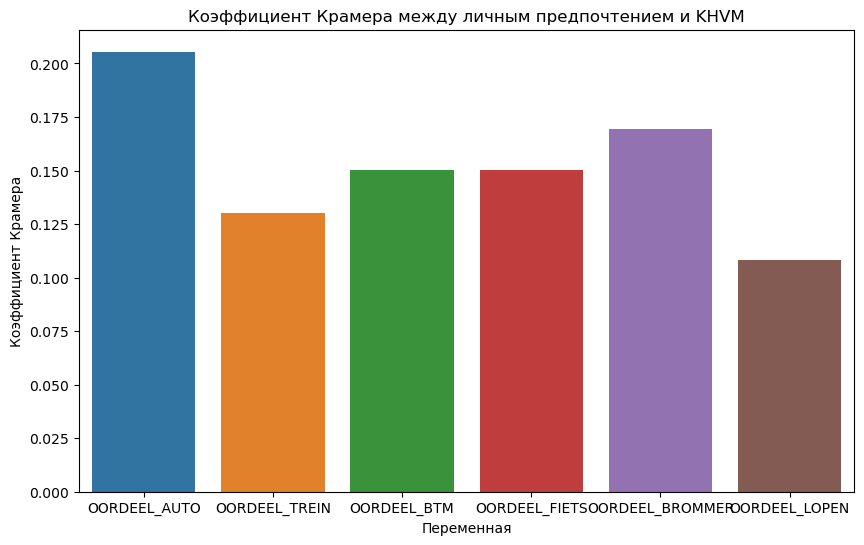

In [295]:
# Функция для вычисления коэффициента Крамера
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2 /= min(k - 1, r - 1)
    return np.sqrt(phi2)

categorical_vars = [
    'OORDEEL_AUTO',
    'OORDEEL_TREIN',
    'OORDEEL_BTM',
    'OORDEEL_FIETS',
    'OORDEEL_BROMMER',
    'OORDEEL_LOPEN'
]

target_var = 'KHVM'

results = []

# Вычисляем коэффициент Крамера для каждой категориальной переменной
for var in categorical_vars:
    v = cramers_v(df_new[var], df_new[target_var])
    results.append({'Переменная': var, 'Коэффициент Крамера': v})
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.barplot(x='Переменная', y='Коэффициент Крамера', data=results_df)
plt.title("Коэффициент Крамера между личным предпочтением и KHVM")
plt.show()

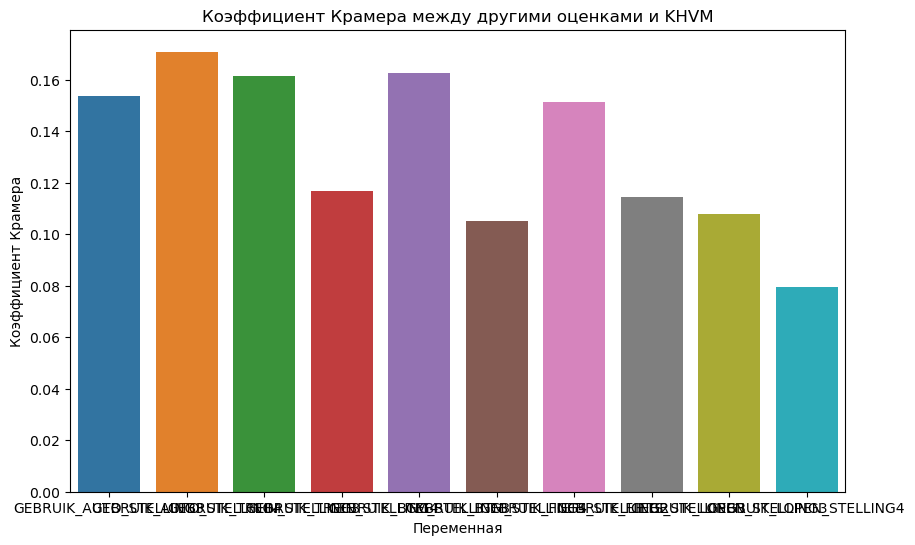

In [296]:
categorical_vars = [
    'GEBRUIK_AUTO_STELLING3', 
    'GEBRUIK_AUTO_STELLING4', 
    'GEBRUIK_TREIN_STELLING3', 
    'GEBRUIK_TREIN_STELLING4', 
    'GEBRUIK_BTM_STELLING3', 
    'GEBRUIK_BTM_STELLING4',
    'GEBRUIK_FIETS_STELLING2', 
    'GEBRUIK_FIETS_STELLING3', 
    'GEBRUIK_LOPEN_STELLING3',
    'GEBRUIK_LOPEN_STELLING4'
]

target_var = 'KHVM'

results = []

# Вычисляем коэффициент Крамера для каждой категориальной переменной
for var in categorical_vars:
    v = cramers_v(df_new[var], df_new[target_var])
    results.append({'Переменная': var, 'Коэффициент Крамера': v})
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.barplot(x='Переменная', y='Коэффициент Крамера', data=results_df)
plt.title("Коэффициент Крамера между другими оценками и KHVM")
plt.show()

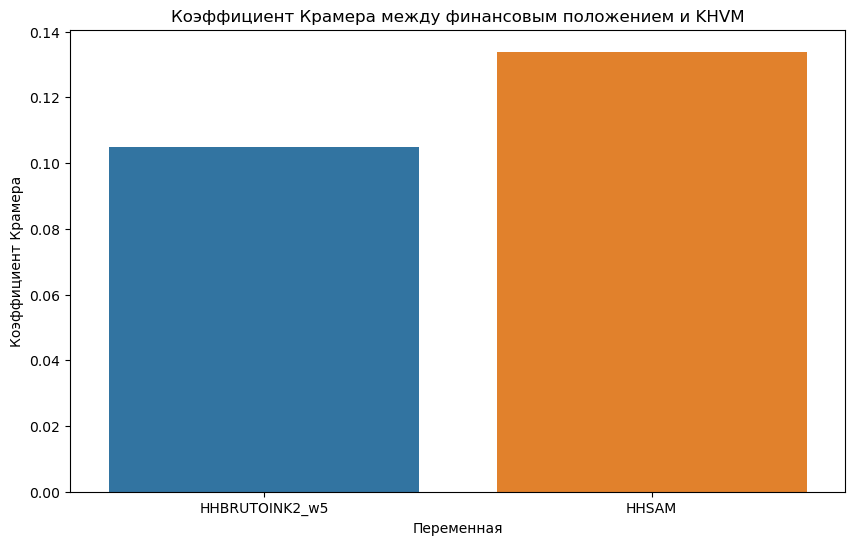

In [297]:
categorical_vars = [
    'HHBRUTOINK2_w5',
    'HHSAM',
]

target_var = 'KHVM'

results = []

# Вычисляем коэффициент Крамера для каждой категориальной переменной
for var in categorical_vars:
    v = cramers_v(df_new[var], df_new[target_var])
    results.append({'Переменная': var, 'Коэффициент Крамера': v})
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.barplot(x='Переменная', y='Коэффициент Крамера', data=results_df)
plt.title("Коэффициент Крамера между финансовым положением и KHVM")
plt.show()

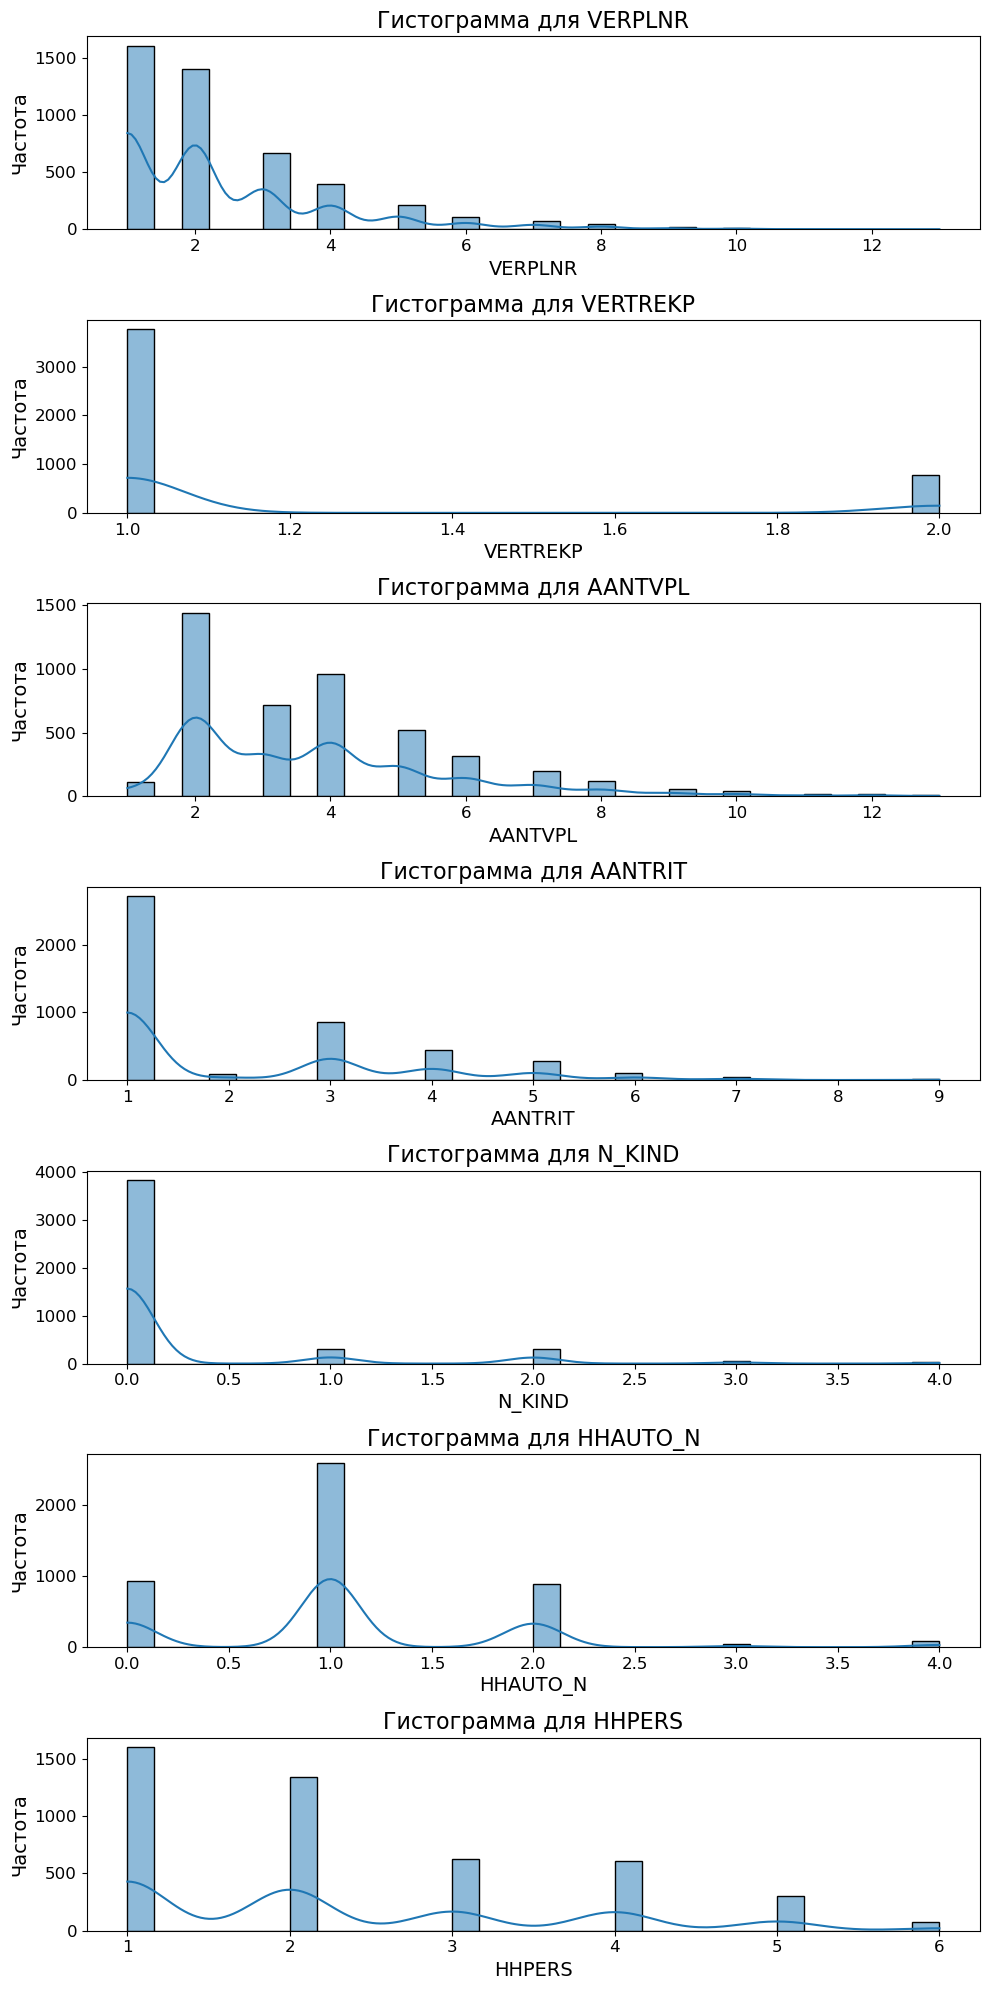

In [298]:
plt.figure(figsize=(10, 20))

for i, col in enumerate(['VERPLNR', 'VERTREKP', 'AANTVPL', 'AANTRIT', 'N_KIND', 'HHAUTO_N', 'HHPERS']):
    plt.subplot(7, 1, i + 1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Гистограмма для {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.tick_params(labelsize=12)

plt.tight_layout()
plt.show() 

Распределение не категориальных колонок в датасете

In [299]:
# Список не категориальных колонок
excluded_columns = ['HHID', 'PERSID', 'VPLID', 'RitID', 'VERPLNR', 'VERTREKP', 'AANTVPL', 
                    'AANTRIT', 'N_KIND', 'HHAUTO_N', 'HHPERS']

categorical_cols = df.select_dtypes(include=['object', 'category', 'int', 'float']).columns
categorical_cols = [col for col in categorical_cols if col not in excluded_columns]

# DataFrame для коэффициентов корреляции
corr_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# коэффициенты Крамера
for col1 in categorical_cols:
    for col2 in categorical_cols:
        corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
        
corr_matrix = corr_matrix.astype(float)

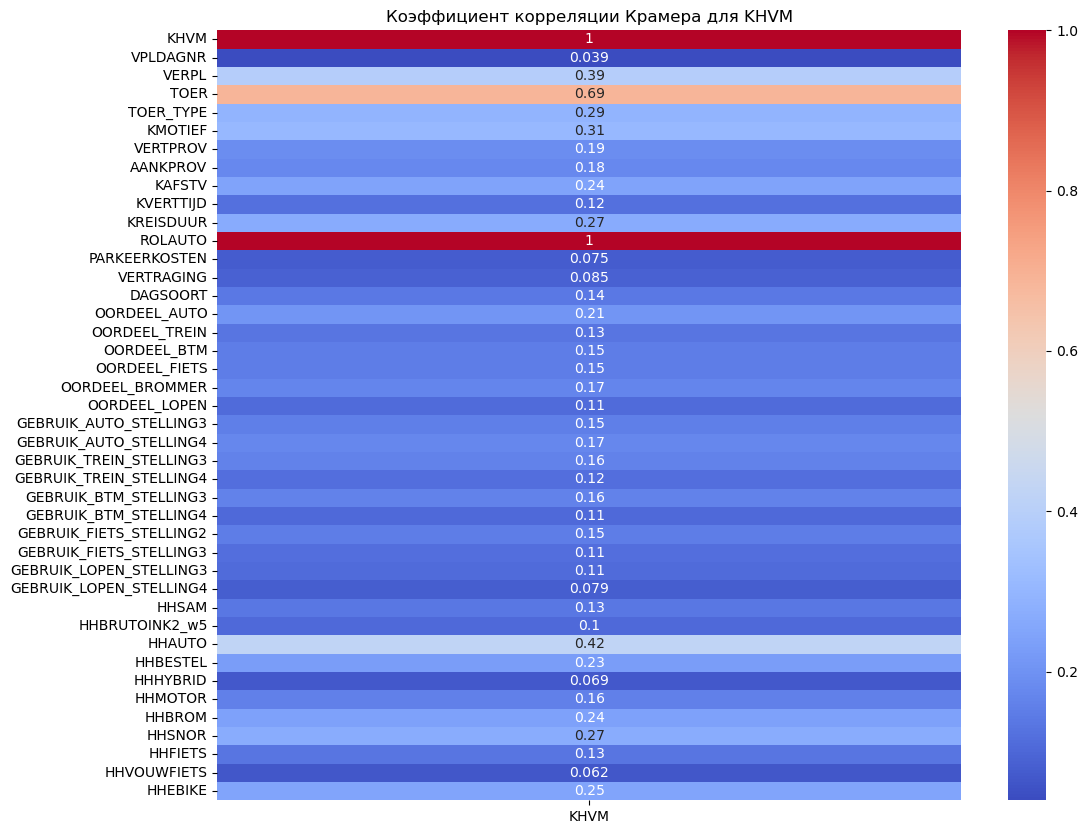

In [300]:
target_variable = 'KHVM'

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[[target_variable]], annot=True, cmap='coolwarm', cbar=True)
plt.title(f'Коэффициент корреляции Крамера для {target_variable}')
plt.show()

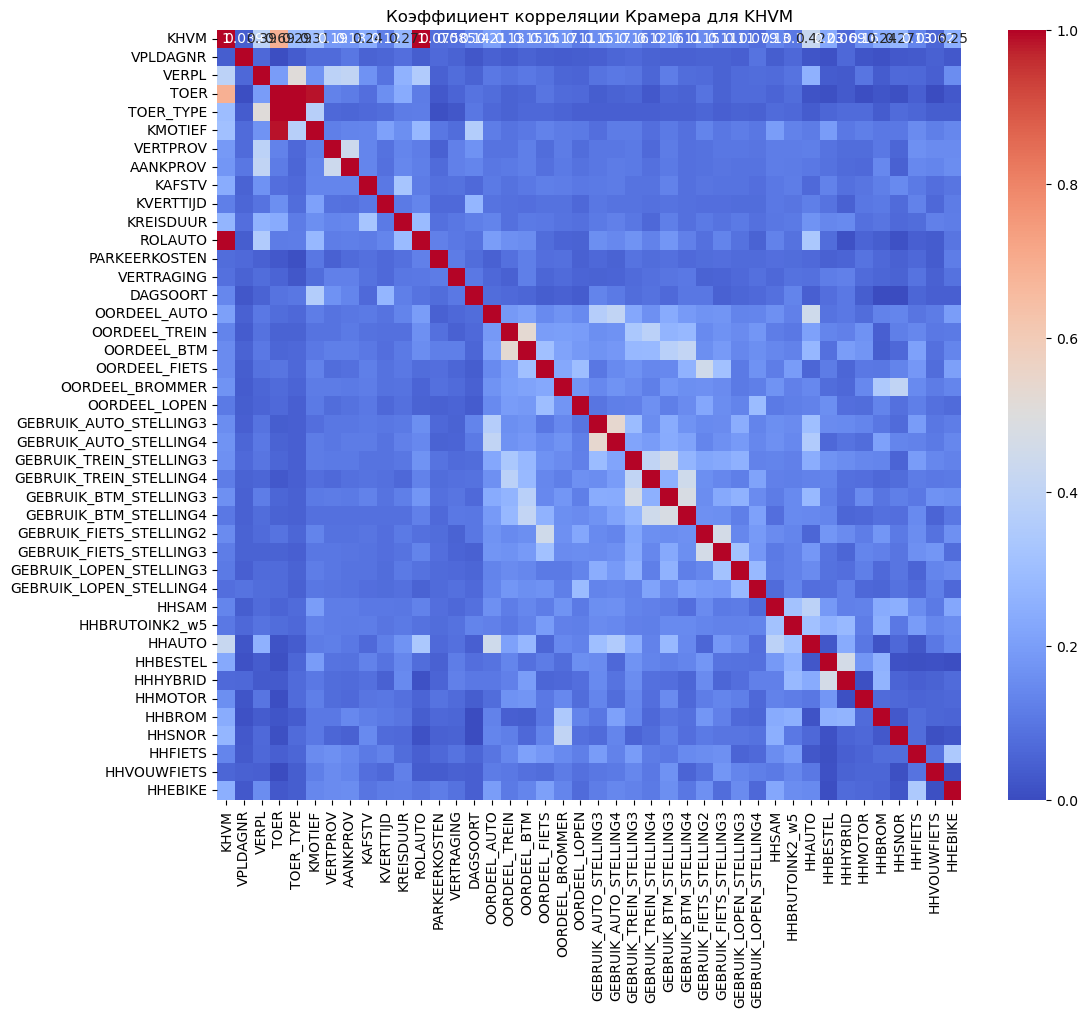

In [301]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title(f'Коэффициент корреляции Крамера для {target_variable}')
plt.show()

Общая матрица нужна, чтобы отследить, имеется ли заметная корреляция между переменными, отличными от таргетной, чтобы избежать очевидной мультиколлинеарности

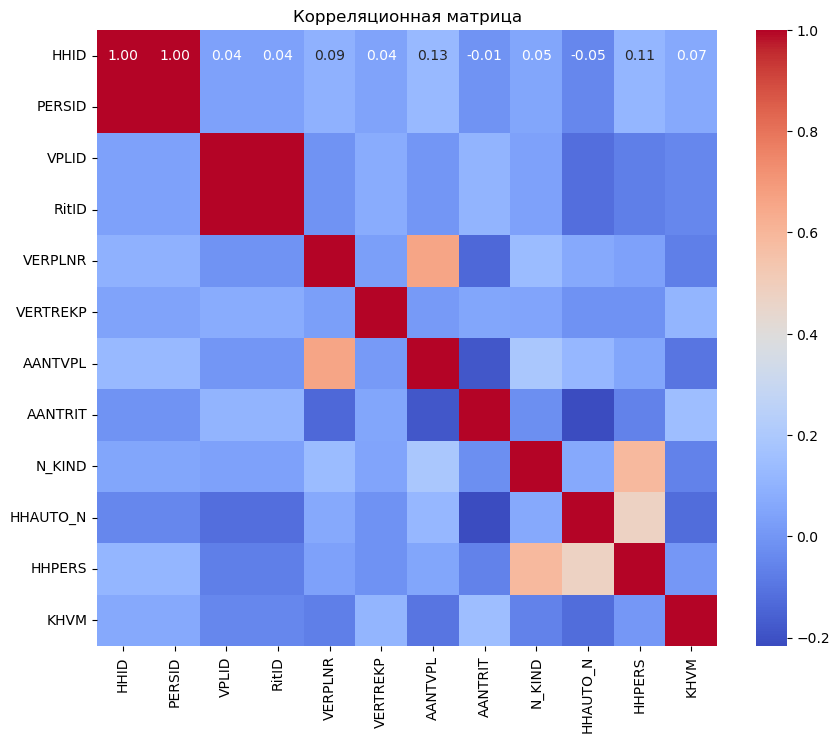

In [302]:
df_filtered = df[excluded_columns] 

columns_to_use = excluded_columns.copy()
if 'KHVM' not in columns_to_use:
    columns_to_use.append('KHVM')
    
df_selected = df[columns_to_use]

correlation_matrix = df_selected.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

Зависимости для численных премененных 

# ВАЖНО

Где-то на этом этапе я заметила, что данные из файла с описанием не везде совпадают с содержимым файла с данными, поэтому в процессе обработки данных я могу делать выводы, противоречащие фактическому содержанию датасета. Мне очень не хочется вручную перебирать 56 колонок чуть ли не построчно, чтобы отловить все эти ошибки, надеюсь на понимание

# Генерация новых данных для создания сбалансированных классов 

In [303]:
X = df.drop('KHVM', axis=1)
y = df['KHVM']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
resampled_data['KHVM'] = y_resampled

df_khvm = resampled_data.groupby('KHVM').size().reset_index().rename(columns = {'KHVM': 'Транспорт', 0: 'Количество поездок'}).sort_values('Количество поездок', ascending=False)

fig = px.bar(df_khvm, x='Транспорт', y = 'Количество поездок', text_auto=True)
fig.update_layout(title = {'text': 'Использование видов транспорта', 'x': 0.5})
fig.show()

Честно говоря, я не доверяю этому методу, поэтому хочу построить все те же графики для нового датасета. Можно перейти сразу к блоку с анализом результатов

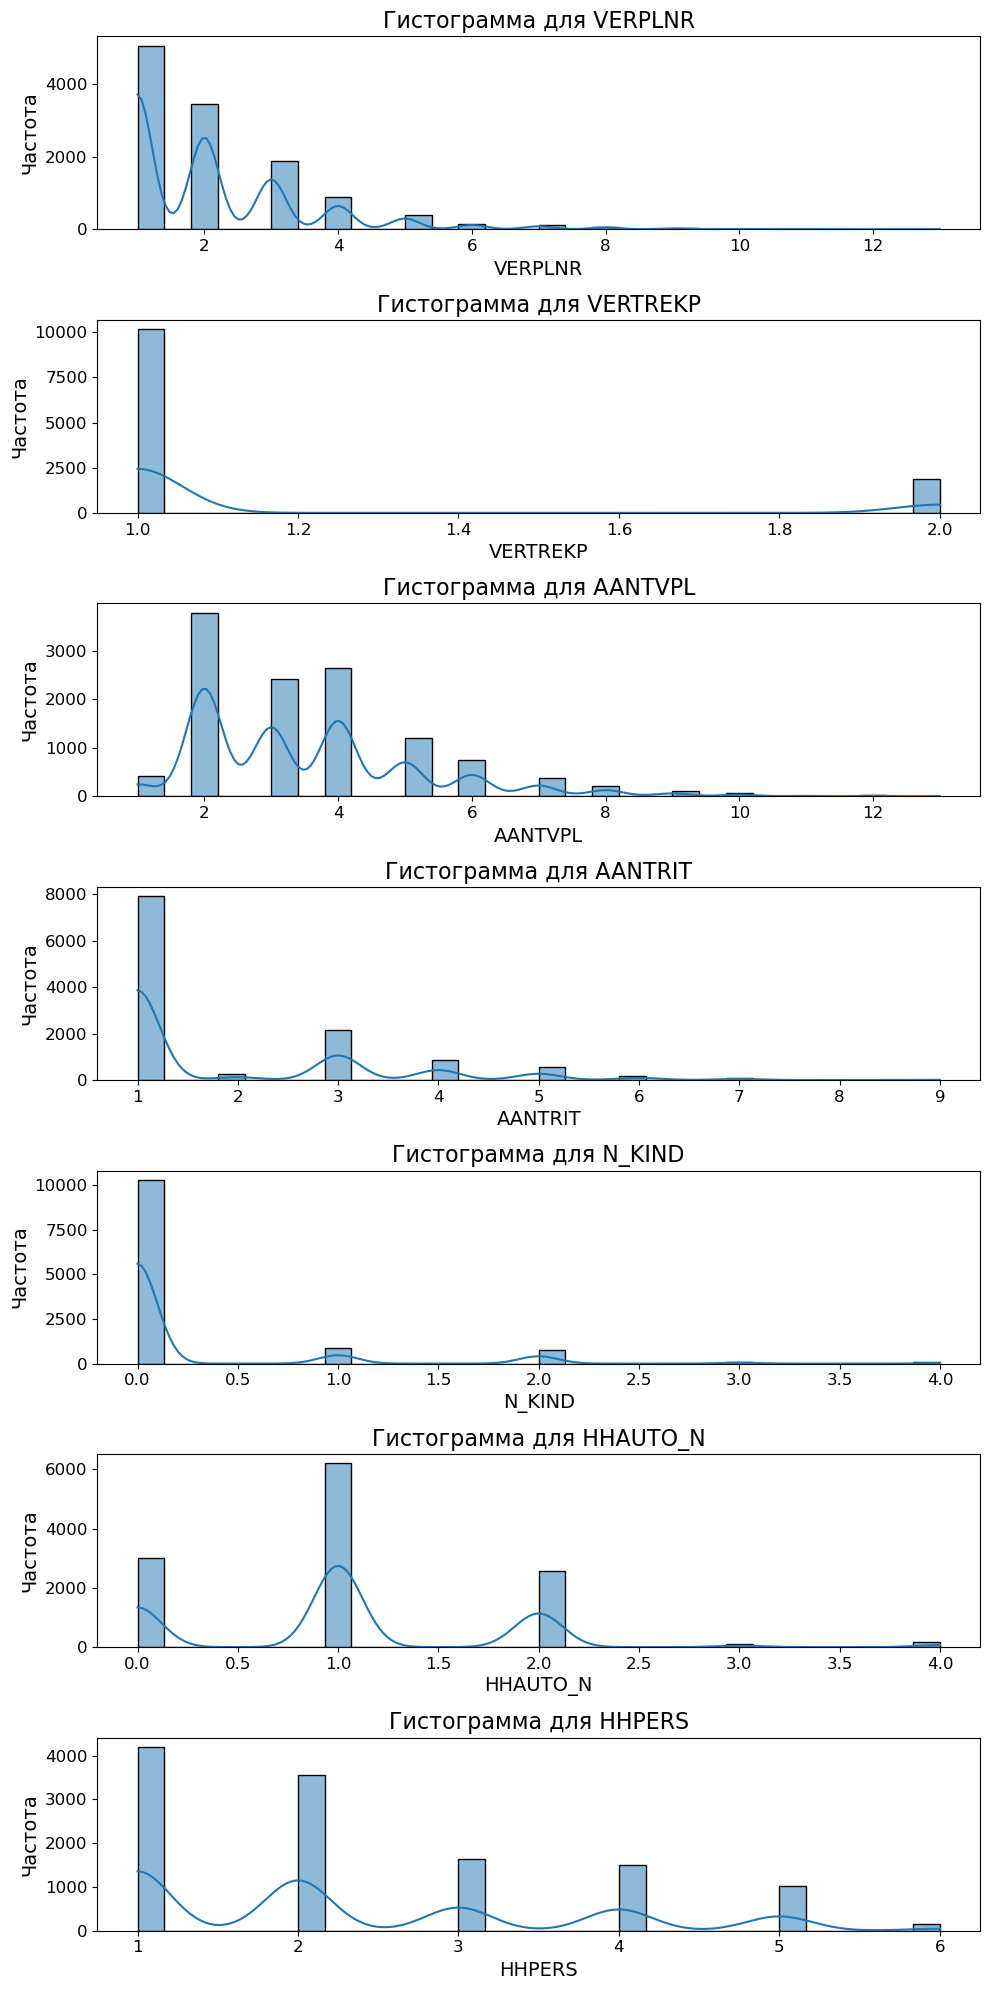

In [304]:
plt.figure(figsize=(10, 20))

for i, col in enumerate(['VERPLNR', 'VERTREKP', 'AANTVPL', 'AANTRIT', 'N_KIND', 'HHAUTO_N', 'HHPERS']):
    plt.subplot(7, 1, i + 1)
    sns.histplot(resampled_data[col], bins=30, kde=True)
    plt.title(f'Гистограмма для {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.tick_params(labelsize=12)

plt.tight_layout()
plt.show() 

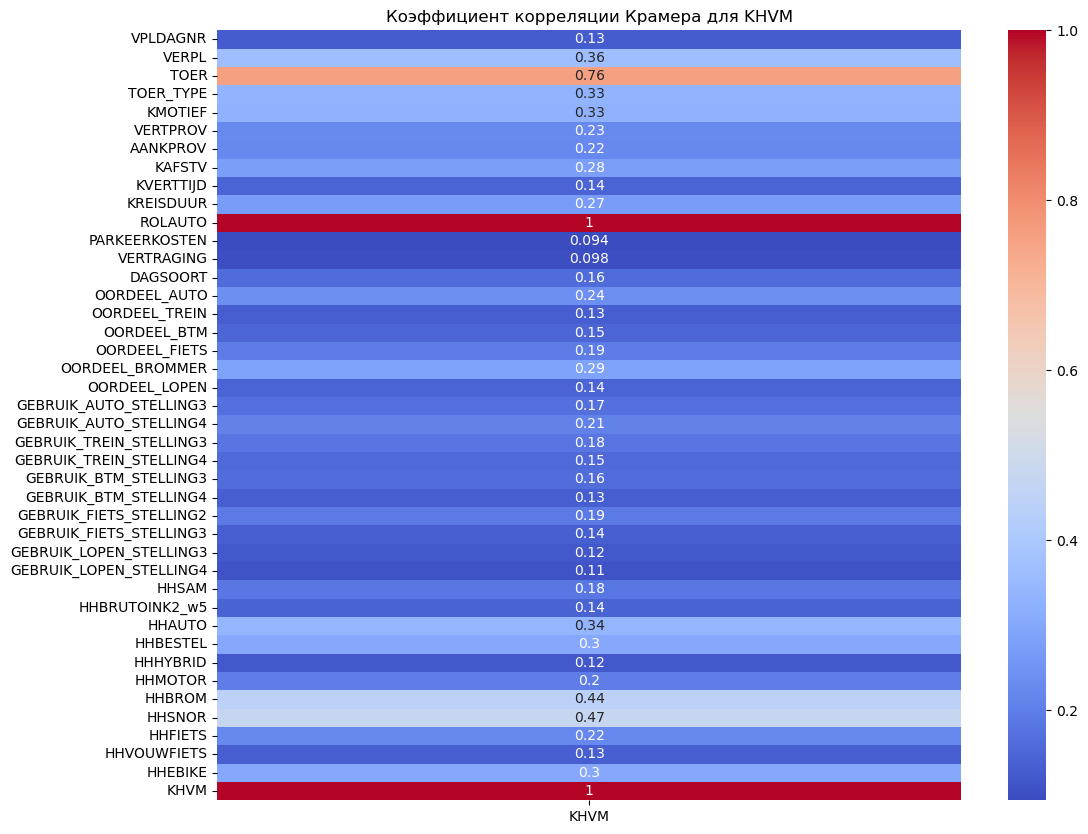

In [305]:
# Список не категориальных колонок
excluded_columns = ['HHID', 'PERSID', 'VPLID', 'RitID', 'VERPLNR', 'VERTREKP', 'AANTVPL', 
                    'AANTRIT', 'N_KIND', 'HHAUTO_N', 'HHPERS']

categorical_cols = resampled_data.select_dtypes(include=['object', 'category', 'int', 'float']).columns
categorical_cols = [col for col in categorical_cols if col not in excluded_columns]

# DataFrame для коэффициентов корреляции
corr_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# коэффициенты Крамера
for col1 in categorical_cols:
    for col2 in categorical_cols:
        corr_matrix.loc[col1, col2] = cramers_v(resampled_data[col1], resampled_data[col2])
        
corr_matrix = corr_matrix.astype(float)

target_variable = 'KHVM'

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[[target_variable]], annot=True, cmap='coolwarm', cbar=True)
plt.title(f'Коэффициент корреляции Крамера для {target_variable}')
plt.show()

Результат схож, можно пользоваться новым датафреймом

Отбор признаков: у нас всего 10 фич с коэффициентом корреляции от 0,3, это где-то 18% от всех данных. Полагаю, между фичами и таргетной переменной могут существовать неочевидные связи, которые нужно очень кропотливо искать. Я планирую попробовать обучить модель на 10 фичах и на всех и сравнить результаты. 

# Моделирование

## обучение на всех данных после оверсамплинга

In [306]:
X = resampled_data.drop(columns=['KHVM', 'ROLAUTO', 'HHID', 'PERSID', 'VPLID', 'RitID'])
y = resampled_data['KHVM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

# Инициализация H2O
h2o.init(max_mem_size='8G')

# Создание H2OFrame
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

h2o_train = h2o.H2OFrame(train_df)
h2o_test = h2o.H2OFrame(test_df)

target = 'KHVM'
h2o_train[target] = h2o_train[target].asfactor()
h2o_test[target] = h2o_test[target].asfactor()

features = list(h2o_train.columns)
features.remove(target)

# Настройка и запуск AutoML
aml = H2OAutoML(
    max_models=10,
    max_runtime_secs=1000,
    seed=42,
    sort_metric='logloss',
    balance_classes=True,
    exclude_algos=['StackedEnsemble', 'DeepLearning']
)
aml.train(x=features, y=target, training_frame=h2o_train, validation_frame=h2o_test)

# Проверка наличия моделей
if aml.leaderboard.nrows == 0:
    print("Ошибка: модели не были построены. Проверьте данные и параметры.")
else:
    print("\nТаблица лидеров:")
    print(aml.leaderboard.head())

    best_model = aml.leader
    print(f"\nЛучшая модель: {best_model.model_id}")

    # Прогнозирование
    preds = best_model.predict(h2o_test).as_data_frame()
    y_true = h2o_test[target].as_data_frame().values.ravel()
    y_pred = preds['predict'].values
    proba_cols = [col for col in preds.columns if col != 'predict']
    y_proba = preds[proba_cols].values

    # Расчет метрик
    print("\nМетрики качества:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R²: {r2_score(y_true, y_pred):.2f}")

    # Матрица ошибок и отчет
    print("\nМатрица ошибок:")
    print(confusion_matrix(y_true, y_pred))

    print("\nОтчет классификации:")
    print(classification_report(y_true, y_pred))

# Завершение работы H2O
h2o.shutdown(prompt=False)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.401-b10, mixed mode)
  Starting server from C:\Users\User\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\User\AppData\Local\Temp\tmpr1zbkh9_
  JVM stdout: C:\Users\User\AppData\Local\Temp\tmpr1zbkh9_\h2o_User_started_from_python.out
  JVM stderr: C:\Users\User\AppData\Local\Temp\tmpr1zbkh9_\h2o_User_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,H2O_from_python_User_88l5y9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.096 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
07:43:11.560: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
07:43:11.581: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%

Таблица лидеров:
model_id                                      logloss    mean_per_class_error      rmse        mse
GBM_1_AutoML_1_20250523_74311               0.0937187               0.0313807  0.160126  0.0256404
GBM_4_AutoML_1_20250523_74311               0.0955767               0.0331416  0.161878  0.0262046
GBM_2_AutoML_1_20250523_74311               0.0993332            

Очень смущает  accuracy = 0,97. Очевидно, модель переобучена, что, вероятно, связано с неправильным выбором входных данных. Пробуем другие

In [307]:
X = df.drop(columns=['KHVM', 'ROLAUTO', 'HHID', 'PERSID', 'VPLID', 'RitID'])
y = df['KHVM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

# Инициализация H2O
h2o.init(max_mem_size='8G')

# Создание H2OFrame
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

h2o_train = h2o.H2OFrame(train_df)
h2o_test = h2o.H2OFrame(test_df)

target = 'KHVM'
h2o_train[target] = h2o_train[target].asfactor()
h2o_test[target] = h2o_test[target].asfactor()

features = list(h2o_train.columns)
features.remove(target)

# Настройка и запуск AutoML
aml = H2OAutoML(
    max_models=10,
    max_runtime_secs=1000,
    seed=42,
    sort_metric='logloss',
    balance_classes=True,
    exclude_algos=['StackedEnsemble', 'DeepLearning']
)
aml.train(x=features, y=target, training_frame=h2o_train, validation_frame=h2o_test)

# Проверка наличия моделей
if aml.leaderboard.nrows == 0:
    print("Ошибка: модели не были построены. Проверьте данные и параметры.")
else:
    print("\nТаблица лидеров:")
    print(aml.leaderboard.head())

    best_model = aml.leader
    print(f"\nЛучшая модель: {best_model.model_id}")

    # Прогнозирование
    preds = best_model.predict(h2o_test).as_data_frame()
    y_true = h2o_test[target].as_data_frame().values.ravel()
    y_pred = preds['predict'].values
    proba_cols = [col for col in preds.columns if col != 'predict']
    y_proba = preds[proba_cols].values

    # Расчет метрик
    print("\nМетрики качества:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R²: {r2_score(y_true, y_pred):.2f}")

    # Матрица ошибок и отчет
    print("\nМатрица ошибок:")
    print(confusion_matrix(y_true, y_pred))

    print("\nОтчет классификации:")
    print(classification_report(y_true, y_pred))

# Завершение работы H2O
h2o.shutdown(prompt=False)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.401-b10, mixed mode)
  Starting server from C:\Users\User\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\User\AppData\Local\Temp\tmpgg3dqs4v
  JVM stdout: C:\Users\User\AppData\Local\Temp\tmpgg3dqs4v\h2o_User_started_from_python.out
  JVM stderr: C:\Users\User\AppData\Local\Temp\tmpgg3dqs4v\h2o_User_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,H2O_from_python_User_r1iw2j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.096 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
07:54:30.940: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
07:54:30.963: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%

Таблица лидеров:
model_id                                      logloss    mean_per_class_error      rmse        mse
GBM_1_AutoML_1_20250523_75430                0.329715                0.156623  0.294158  0.0865287
GBM_3_AutoML_1_20250523_75430                0.337065                0.160581  0.29957   0.0897423
GBM_2_AutoML_1_20250523_75430                0.341857            

Лучше, но всё ещё много, попробуем на переменных с хорошими коэффициентами корреляции

In [308]:
columns_to_use = ['VERTREKP', 'AANTRIT', 'VERPL', 'TOER', 'KMOTIEF', 'TOER_TYPE', 
                            'HHAUTO', 'HHBESTEL', 'HHBROM', 'HHSNOR', 'HHEBIKE']

X = resampled_data[columns_to_use]
y = resampled_data['KHVM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

# Инициализация H2O
h2o.init(max_mem_size='8G')

# Создание H2OFrame
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

h2o_train = h2o.H2OFrame(train_df)
h2o_test = h2o.H2OFrame(test_df)

target = 'KHVM'
h2o_train[target] = h2o_train[target].asfactor()
h2o_test[target] = h2o_test[target].asfactor()

features = list(h2o_train.columns)
features.remove(target)

# Настройка и запуск AutoML
aml = H2OAutoML(
    max_models=10,
    max_runtime_secs=1000,
    seed=42,
    sort_metric='logloss',
    balance_classes=True,
    exclude_algos=['StackedEnsemble', 'DeepLearning']
)
aml.train(x=features, y=target, training_frame=h2o_train, validation_frame=h2o_test)

# Проверка наличия моделей
if aml.leaderboard.nrows == 0:
    print("Ошибка: модели не были построены. Проверьте данные и параметры.")
else:
    print("\nТаблица лидеров:")
    print(aml.leaderboard.head())

    best_model = aml.leader
    print(f"\nЛучшая модель: {best_model.model_id}")

    # Прогнозирование
    preds = best_model.predict(h2o_test).as_data_frame()
    y_true = h2o_test[target].as_data_frame().values.ravel()
    y_pred = preds['predict'].values
    proba_cols = [col for col in preds.columns if col != 'predict']
    y_proba = preds[proba_cols].values

    # Расчет метрик
    print("\nМетрики качества:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R²: {r2_score(y_true, y_pred):.2f}")

    # Матрица ошибок и отчет
    print("\nМатрица ошибок:")
    print(confusion_matrix(y_true, y_pred))

    print("\nОтчет классификации:")
    print(classification_report(y_true, y_pred))

# Завершение работы H2O
h2o.shutdown(prompt=False)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.401-b10, mixed mode)
  Starting server from C:\Users\User\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\User\AppData\Local\Temp\tmpdix9186d
  JVM stdout: C:\Users\User\AppData\Local\Temp\tmpdix9186d\h2o_User_started_from_python.out
  JVM stderr: C:\Users\User\AppData\Local\Temp\tmpdix9186d\h2o_User_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,H2O_from_python_User_prjt7y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.096 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
08:00:20.990: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
08:00:21.24: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%

Таблица лидеров:
model_id                                      logloss    mean_per_class_error      rmse       mse
GBM_3_AutoML_1_20250523_80020                0.704305                0.295453  0.493767  0.243806
GBM_5_AutoML_1_20250523_80020                0.705173                0.294314  0.493531  0.243572
GBM_2_AutoML_1_20250523_80020                0.706447                

accuracy = 0,71, что очень похоже на справедливое решение для AutoML без глубокого обучения. Вывод: oversampling всё же влияет на результат обучения, но незначительно. Лишние переменные выбрасываем, дальше будем работать со столбцами из списка columns_to_use

# Собственная модель

## попробую сделать ансамбль из логистической регрессии, дерева решений и случайного леса

In [309]:
columns_to_use = ['VERTREKP', 'AANTRIT', 'VERPL', 'TOER', 'KMOTIEF', 'TOER_TYPE', 
                            'HHAUTO', 'HHBESTEL', 'HHBROM', 'HHSNOR', 'HHEBIKE']

X = resampled_data[columns_to_use]
y = resampled_data['KHVM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

In [310]:
# логистическая регрессия

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'none'],
    
}
grid = GridSearchCV(LogisticRegression(multi_class='multinomial', max_iter=200), param_grid, cv=5)
cv_scores = cross_val_score(voting_clf, X_train_scaled, y_train, cv=5)

grid.fit(X_train_scaled, y_train)

best_model = grid.best_estimator_

best_params1 = grid.best_params_

y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


print(f'Best Hyperparameters: {best_params1}')
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy: 0.57
Confusion Matrix:
[[143  73   0   0  23  42   4  16]
 [113  99   2   0   8  51   5  23]
 [  0   0 197  89   1   0   0  15]
 [  0   0  81 195   2   0   0  24]
 [  9   3   0   0 260  30   0   0]
 [111  53   0   6  12  84  15  20]
 [  1  21   0   0   0  18 262   0]
 [ 20  27  46  23  10  33   2 141]]
Classification Report:
              precision    recall  f1-score   support

           1       0.36      0.48      0.41       301
           2       0.36      0.33      0.34       301
           3       0.60      0.65      0.63       302
           4       0.62      0.65      0.63       302
           5       0.82      0.86      0.84       302
           6       0.33      0.28      0.30       301
           7       0.91      0.87      0.89       302
           8       0.59      0.47      0.52       302

    accuracy                           0.57      2413
   macro avg       0.57      0.57      0.57     

In [311]:
# дерево решений

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Настройка гиперпараметров для дерева решений
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

# Лучшая модель
best_model = grid.best_estimator_

# Получение отобранных гиперпараметров и сохранение их в переменной
best_params2 = grid.best_params_

# Прогнозирование на тестовых данных
y_pred = best_model.predict(X_test_scaled)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Вывод результатов
print(f'Best Hyperparameters: {best_params2}')  # Вывод отобранных гиперпараметров
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.70
Confusion Matrix:
[[132 104   0   0  24  30   2   9]
 [ 38 210   2   0   5  28   9   9]
 [  0   0 232  48   0   1   0  21]
 [  2   0  45 237   2   2   0  14]
 [  9   3   0   0 274   4   4   8]
 [ 52  80   2   4  17 108  26  12]
 [  4   1   0   0   0   9 288   0]
 [ 24  20   4  11  10  21   5 207]]
Classification Report:
              precision    recall  f1-score   support

           1       0.51      0.44      0.47       301
           2       0.50      0.70      0.58       301
           3       0.81      0.77      0.79       302
           4       0.79      0.78      0.79       302
           5       0.83      0.91      0.86       302
           6       0.53      0.36      0.43       301
           7       0.86      0.95      0.91       302
           8       0.74      0.69      0.71       302

    accuracy                           0.70      2413
   macro avg 

In [312]:
# случайный лес

# Масштабирование признаков (не обязательно для случайного леса, но может быть полезно)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Настройка гиперпараметров для случайного леса
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

# Лучшая модель
best_model = grid.best_estimator_

# Получение отобранных гиперпараметров и сохранение их в переменной
best_params3 = grid.best_params_

# Прогнозирование на тестовых данных
y_pred = best_model.predict(X_test_scaled)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Вывод результатов
print(f'Best Hyperparameters: {best_params3}')  # Вывод отобранных гиперпараметров
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Best Hyperparameters: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.71
Confusion Matrix:
[[127  97   0   1  24  38   3  11]
 [ 34 207   2   0   5  32  10  11]
 [  0   0 234  49   0   1   0  18]
 [  0   0  46 239   2   2   0  13]
 [  7   5   0   0 274   4   4   8]
 [ 52  67   2   4  16 120  28  12]
 [  5   1   0   0   1   6 289   0]
 [ 23  17   4  10  10  20   6 212]]
Classification Report:
              precision    recall  f1-score   support

           1       0.51      0.42      0.46       301
           2       0.53      0.69      0.60       301
           3       0.81      0.77      0.79       302
           4       0.79      0.79      0.79       302
           5       0.83      0.91      0.86       302
           6       0.54      0.40      0.46       301
           7       0.85      0.96      0.90       302
           8       0.74      0.70      0.72       302

    accuracy                           0.7

## собираем франкенштейна

In [314]:
# Настройка базовых моделей
log_clf = LogisticRegression(random_state=42, **best_params1)
tree_clf = DecisionTreeClassifier(random_state=42, **best_params2)
forest_clf = RandomForestClassifier(random_state=42, **best_params3)

# Создание ансамбля 
voting_clf = VotingClassifier(estimators=[
    ('logistic', log_clf),
    ('decision_tree', tree_clf),
    ('random_forest', forest_clf)
], voting='soft')

# Оценка производительности с помощью кросс-валидации
cv_scores = cross_val_score(voting_clf, X_train_scaled, y_train, cv=5)  # 5-кратная кросс-валидация

# Вывод результатов кросс-валидации
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average CV Score: {np.mean(cv_scores):.2f}')

# Обучение ансамбля на тренировочных данных
voting_clf.fit(X_train_scaled, y_train)

# Предсказания на тестовых данных
y_pred = voting_clf.predict(X_test_scaled)

# Оценка качества
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Cross-Validation Scores: [0.71620922 0.69274611 0.6984456  0.69792746 0.70310881]
Average CV Score: 0.70
Accuracy: 0.70
Confusion Matrix:
[[134  93   0   0  24  36   3  11]
 [ 36 201   2   0   6  36   9  11]
 [  0   0 249  48   0   1   0   4]
 [  0   0  60 236   2   2   0   2]
 [  9   3   0   0 274   8   3   5]
 [ 55  64   0   6  17 123  27   9]
 [  4   1   0   0   0  10 287   0]
 [ 26  15  33   9  10  19   5 185]]
Classification Report:
              precision    recall  f1-score   support

           1       0.51      0.45      0.47       301
           2       0.53      0.67      0.59       301
           3       0.72      0.82      0.77       302
           4       0.79      0.78      0.79       302
           5       0.82      0.91      0.86       302
           6       0.52      0.41      0.46       301
           7       0.86      0.95      0.90       302
           8       0.81      0.61      0.70       302

    accuracy                           0.70      2413
   macro avg    

Факир был пьян, фокус не удался. В целом моя модель почти догнала AutoML (что немного грустно), так что результат есть 

# Интерпретация

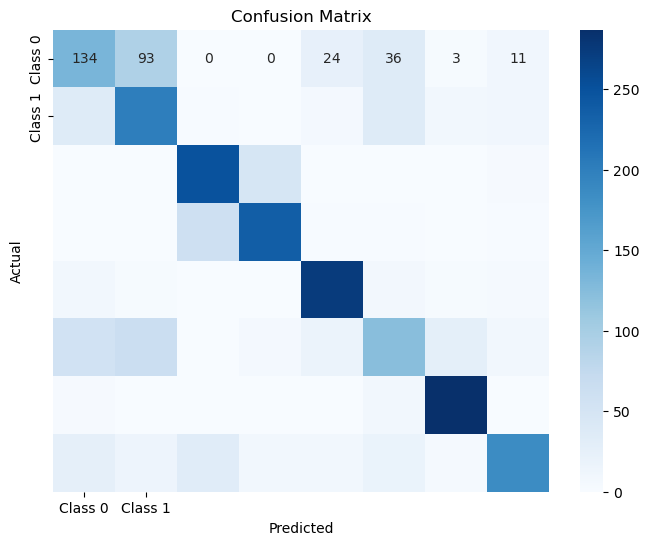

In [316]:
# матрица ошибок 

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

есть классы, которые предсказываются хуже, чем другие, но в целом ошибок не слишком много в соотношении с правильно предсказанными данными. можно доработать анализ стыковых вариантов (полагаю, это происходит потому, что в данных много слабых зависимостей)

In [323]:
# отбор признаков по значимости

for name, clf in voting_clf.named_estimators_.items():
    print(f"Важность признаков для модели {name}:")
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1]
        for i in indices[:5]:
            print(f"  Признак {i}: {importances[i]}")
    else:
        print("  Эта модель не поддерживает feature_importances_")

Важность признаков для модели logistic:
  Эта модель не поддерживает feature_importances_
Важность признаков для модели decision_tree:
  Признак 1: 0.2511357027611316
  Признак 5: 0.1831781649158132
  Признак 4: 0.1743940665202139
  Признак 9: 0.07774550212032161
  Признак 8: 0.07612703857437107
Важность признаков для модели random_forest:
  Признак 1: 0.20040124333291956
  Признак 4: 0.17615714390433238
  Признак 5: 0.12020799225595438
  Признак 2: 0.09495390718801788
  Признак 9: 0.08383244779551244


Мы видим, что признаки 1, 4 и 5 были особенно важны для двух моделей из трех. Думаю, это признаки "точка отправления", "показатель круговой поездки" и "цель поездки". 

In [335]:
interesting_indices = [10, 25, 42]

for index in interesting_indices:
    # Получаем исходные значения признаков и предсказания
    original_features = X_test.iloc[index].values 
    original_prediction = voting_clf.predict([original_features])[0]
    
    print(f'\nНаблюдение с индексом {index}:')
    print(f'Исходное предсказание: {original_prediction}')
    print(f'Признаки: {original_features}')

    # Анализ влияния признаков
    for i in range(len(original_features)):
        modified_features = original_features.copy()
        modified_features[i] += 0.1
        modified_prediction = voting_clf.predict([modified_features])[0]
        print(f'Изменение Признака {i} до {modified_features[i]:.2f} изменяет предсказание на: {modified_prediction}')


Наблюдение с индексом 10:
Исходное предсказание: 1
Признаки: [1 1 1 0 1 9 1 0 0 0 0]
Изменение Признака 0 до 1.00 изменяет предсказание на: 1
Изменение Признака 1 до 1.00 изменяет предсказание на: 1
Изменение Признака 2 до 1.00 изменяет предсказание на: 1
Изменение Признака 3 до 0.00 изменяет предсказание на: 1
Изменение Признака 4 до 1.00 изменяет предсказание на: 1
Изменение Признака 5 до 9.00 изменяет предсказание на: 1
Изменение Признака 6 до 1.00 изменяет предсказание на: 1
Изменение Признака 7 до 0.00 изменяет предсказание на: 1
Изменение Признака 8 до 0.00 изменяет предсказание на: 1
Изменение Признака 9 до 0.00 изменяет предсказание на: 1
Изменение Признака 10 до 0.00 изменяет предсказание на: 1

Наблюдение с индексом 25:
Исходное предсказание: 4
Признаки: [1 3 1 0 1 9 0 0 0 0 0]
Изменение Признака 0 до 1.00 изменяет предсказание на: 4
Изменение Признака 1 до 3.00 изменяет предсказание на: 4
Изменение Признака 2 до 1.00 изменяет предсказание на: 4
Изменение Признака 3 до 0.00 

все выбранные признаки довольно сильно влияют на результат модели